In [1]:
import numpy as np
from PIL import Image
from shapely.geometry import Polygon, box
from scipy import ndimage
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import LineString, Point
import pandas as pd
import networkx as nx
from skimage.morphology import skeletonize
from scipy.spatial import KDTree
import pandana as pdna
import random

In [2]:
start_x, start_y = 330874, 4684290
scale=2
utm_zone = 19
utm_crs = f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

max_floors=21

cmap={
    'Resi' : [255,255,51],
    'Comm' : [228,26,28],
    'Inst' : [55,126,184],
    'None' : [0,0,0],
    'Open' : [77,175,74],
    'Road': [100, 100, 100]
}
rgb_label_dict={}
label_to_lu={}
for i, (k,v) in enumerate(cmap.items()):
    rgb_label_dict[tuple(v)]=i
    label_to_lu[i]=k

In [3]:
image = Image.open("../Diffusion-Models-pytorch/test_image.png")

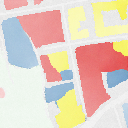

In [4]:
image

In [23]:
def rgb_distance(rgb1, rgb2):
    return np.sqrt(np.sum([(rgb1[i] - rgb2[i]) ** 2 for i in range(3)]))

def closest_rgb_label(pixel, rgb_label_dict):
    min_distance = float('inf')
    closest_label = None
    for rgb, label in rgb_label_dict.items():
        distance = rgb_distance(pixel[:3], rgb)
        if distance < min_distance:
            min_distance = distance
            closest_label = label
    return closest_label

def dfs(i, j, visited, region, label_img):
    if i < 0 or j < 0 or i >= label_img.shape[0] or j >= label_img.shape[1] or visited[i, j]:
        return

    visited[i, j] = True
    region.append((j, i))

    label = label_img[i, j]
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
        ni, nj = i + dy, j + dx
        if 0 <= ni < label_img.shape[0] and 0 <= nj < label_img.shape[1] and label_img[ni, nj] == label:
            dfs(ni, nj, visited, region, label_img)

def create_geodataframe(image, rgb_label_dict):
    # Convert the RGBA PIL image to a numpy array
    np_img = np.array(image)
    np_img= np.flip(np_img, axis=0)

    # Identify the closest RGB value and its corresponding label for each pixel
    label_img = np.zeros((np_img.shape[0], np_img.shape[1]), dtype=int)
    for i in range(np_img.shape[0]):
        for j in range(np_img.shape[1]):
            label_img[i, j] = closest_rgb_label(np_img[i, j], rgb_label_dict)

    # Find contiguous regions with the same label using DFS
    visited = np.zeros_like(label_img, dtype=bool)
    polygons = []
    labels = []
    avg_alphas = []

    for i in range(label_img.shape[0]):
        for j in range(label_img.shape[1]):
            if not visited[i, j]:
                region = []
                dfs(i, j, visited, region, label_img)
                if region:
                    # Create a unit-sized box around each pixel and use the union of all the boxes in each region as the polygon
                    region_boxes = [box(x, y, x+1, y+1) for x, y in region]
                    polygon = unary_union(region_boxes)

                    label = label_img[i, j]
                    avg_alpha = np.mean(np_img[[coord[1] for coord in region], [coord[0] for coord in region], 3])

                    polygons.append(polygon)
                    labels.append(label)
                    avg_alphas.append(avg_alpha)
                    
    data = {'label': labels, 'avg_alpha': avg_alphas, 'geometry': polygons}
    gdf=gpd.GeoDataFrame(data=data, geometry='geometry')
    gdf=gdf.explode(ignore_index=True)
    gdf['id']=gdf.index.copy()
    gdf['floors']=(gdf['avg_alpha']*(max_floors/255)).astype(int)
    gdf.geometry=gdf.geometry.scale(xfact=scale, yfact=scale, origin=[0,0,0]).translate(
        xoff=start_x, yoff=start_y, zoff=0.0)
    centroids=gdf.centroid
    gdf['x']=[c.x for c in centroids]
    gdf['y']=[c.y for c in centroids]
    return gdf, label_img

# Function to compute the angle between two vectors
def compute_angle(node1, node2, node3):
    vector1 = np.array(node1) - np.array(node2)
    vector2 = np.array(node3) - np.array(node2)
    dot_product = np.dot(vector1, vector2)
    determinant = np.cross(vector1, vector2)
    angle = np.arctan2(determinant, dot_product) * (180 / np.pi)
    return abs(angle)

# Function to compute the angle between two vectors
def compute_angle(node1, node2, node3):
    vector1 = np.array(node1) - np.array(node2)
    vector2 = np.array(node3) - np.array(node2)
    dot_product = np.dot(vector1, vector2)
    determinant = np.cross(vector1, vector2)
    angle = np.arctan2(determinant, dot_product) * (180 / np.pi)
    return abs(angle)

def road_network(binary_array, simplify=True):
    # Skeletonize the binary road network
    skeleton = skeletonize(binary_array).astype(np.uint8)

    # Create a graph representation of the skeleton
    graph = nx.Graph()
    for y, x in np.argwhere(skeleton == 1):
        graph.add_node((x, y))

    # Connect neighboring nodes
    for node in graph.nodes:
        x, y = node
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (x + dx, y + dy)
            if neighbor in graph.nodes:
                graph.add_edge(node, neighbor, length=np.hypot(dx, dy))
    if simplify:
        # Simplify the graph by removing degree-2 nodes iteratively
        degree_2_nodes = [node for node, degree in graph.degree if degree == 2]
        while degree_2_nodes:
            node = degree_2_nodes.pop(0) # start with the first node
            neighbors = list(graph.neighbors(node))
            edge1_length = graph[node][neighbors[0]]['length']
            edge2_length = graph[node][neighbors[1]]['length']
            if len(neighbors) > 1 and neighbors[0] != neighbors[1]: # check that there are at least 2 different neighbors
                angle = compute_angle(neighbors[0], node, neighbors[1])
                if ((170 <= angle <= 190) or ((edge1_length < 3) and (edge2_length < 3))):
                    graph.remove_node(node) # remove the node from the graph
                    graph.add_edge(neighbors[0], neighbors[1], length=np.hypot(neighbors[0][0] - neighbors[1][0], neighbors[0][1] - neighbors[1][1]))  # Connect the neighbors and calculate new edge length
                    degree_2_nodes = [node for node, degree in graph.degree if degree == 2] # refresh the list of degree-2 nodes

    # Create node and edge tables
    node_table = pd.DataFrame({'node_id': range(len(graph.nodes)), 'x': [node[0] for node in graph.nodes], 'y': [node[1] for node in graph.nodes]})
    node_id_map = {node: node_id for node_id, node in enumerate(graph.nodes)}
    
    # update node positions and scale
    node_table['x']=(scale * node_table['x']) +start_x
    node_table['y']=(scale * node_table['y']) +start_y
    
    edge_table = pd.DataFrame([(node_id_map[u], node_id_map[v], scale * np.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)) for u, v in graph.edges], columns=['from_node', 'to_node', 'distance'])
    
    node_table=node_table.set_index('node_id')
#     nodes_gdf=gpd.GeoDataFrame(
#         node_table, geometry=gpd.points_from_xy(node_table['x'], node_table['y']))
    
    # edge_table=edge_table.merge(
    #     node_table[['x', 'y']], left_on='from_node', right_index=True).rename(
    #     columns = {'x':'from_x', 'y': 'from_y'})
    # edge_table=edge_table.merge(
    #     node_table[['x', 'y']], left_on='to_node', right_index=True).rename(
    #     columns = {'x':'to_x', 'y': 'to_y'})
    # edge_table['geometry']=edge_table.apply(
    #     lambda row: LineString([[row['from_x'], row['from_y'], 0], 
    #                             [row['to_x'], row['to_y'], 0]]), axis=1)
    # edges_gdf=gpd.GeoDataFrame(edge_table, geometry='geometry')
    
    return node_table, edge_table

VIRTUAL_FLOOR_HEIGHT=30
def get_bld_floors_gdf(lu_gdf):
    bld_floors=[]
    for ind, row in lu_gdf.iterrows():
        for i in range(int(row['floors'])):
            base_geom=row['geometry']
            base_coords=list(base_geom.exterior.coords)
            floor_coords=[[c[0], c[1], i*VIRTUAL_FLOOR_HEIGHT] for c in base_coords]
            floor_geom=Polygon(floor_coords)
            new_ind=str(row['id'])+'_'+str(i)
            bld_floors.append({'floor': i, 'lu': row['lu'],
                               'geometry': floor_geom, 'ind': new_ind,
                              'id': row.id, 'area': floor_geom.area})
            bld_floors_gdf=gpd.GeoDataFrame(
                bld_floors, geometry='geometry')
            bld_floors_gdf=bld_floors_gdf.set_index('ind')
    return bld_floors_gdf

def create_virtual_nodes(bld_floors_gdf, max_real_node_id):
    virtual_nodes=[]
    for ind, row in bld_floors_gdf.iterrows():
        centroid=row.geometry.centroid
        x, y= centroid.x, centroid.y
        z=row.geometry.exterior.coords[0][2]
        virtual_nodes.append({'x': x, 'y': y, 'z': z,'bld_ind': ind, 'floor': row['floor']})
    virtual_nodes=pd.DataFrame(virtual_nodes)    
    virtual_nodes['id_int']=list(range(max_real_node_id+1, max_real_node_id+1+len(virtual_nodes)))
    node_id_map={row['bld_ind']: row['id_int'] for ind, row in virtual_nodes.iterrows()}
    return virtual_nodes, node_id_map

def create_vertical_edges(bld_floors_gdf, node_id_map):
    vertical_edges=[]
    for bld in bld_floors_gdf['id'].unique():
        floors_this_bld=bld_floors_gdf.loc[bld_floors_gdf['id']==bld]
        min_floor=floors_this_bld['floor'].min()
        max_floor=floors_this_bld['floor'].max()
        for f in range(min_floor, max_floor-1):
            vertical_edges.append({'from_floor_id': '{}_{}'.format(bld, f),
                                'to_floor_id': '{}_{}'.format(bld, f+1),
                                'travel_time': 10,
                                 'net_type': 'vertical'})
            vertical_edges.append({'to_floor_id': '{}_{}'.format(bld, f),
                                'from_floor_id': '{}_{}'.format(bld, f+1),
                                'travel_time': 10,
                                'net_type': 'vertical'})
    vertical_edges=pd.DataFrame(vertical_edges)
    vertical_edges['from_node']=vertical_edges['from_floor_id'].apply(lambda i: node_id_map[i])
    vertical_edges['to_node']=vertical_edges['to_floor_id'].apply(lambda i: node_id_map[i])
    return vertical_edges

def create_ground_connections(nodes_df, virtual_nodes):
    tree=KDTree(nodes_df[['x', 'y']])
    id_int_ls=list(nodes_df.index)

    ground_virt_nodes=virtual_nodes.loc[virtual_nodes['floor']==0]
    connection_edges=[]
    for ind, row in ground_virt_nodes.iterrows():
        dist, closest_real_node_ind=tree.query([row['x'], row['y']])
        connection_edges.append({'to_node': row['id_int'],
                                'from_node': id_int_ls[closest_real_node_ind],
    #                             'travel_time': dist/(4.8/3.6),
                                 'travel_time':100,
                                'net_type': 'connection'})
        connection_edges.append({'from_node': row['id_int'],
                                'to_node': id_int_ls[closest_real_node_ind],
    #                             'travel_time': dist/(4.8/3.6),
                                 'travel_time':100,
                                'net_type': 'connection'})
    return connection_edges

def create_3d(lu_gdf, nodes_df, edges_df):
    bld_floors_gdf= get_bld_floors_gdf(lu_gdf.loc[~(lu_gdf['lu']=='Road')])
    bld_floors_gdf.crs= utm_crs

    virtual_nodes, node_id_map = create_virtual_nodes(
        bld_floors_gdf, max_real_node_id=nodes_df.index.max())

    vertical_edges = create_vertical_edges(bld_floors_gdf, node_id_map)
    connection_edges=create_ground_connections(nodes_df, virtual_nodes)
    virtual_edges=pd.concat([vertical_edges, pd.DataFrame(connection_edges)])

    virtual_nodes=virtual_nodes.set_index('id_int')
    nodes_df['floor']=0
    nodes_df['z']=0
    all_nodes=pd.concat([nodes_df[['x', 'y', 'z', 'floor']], 
                         pd.DataFrame(virtual_nodes[['x', 'y', 'z', 'floor']])])

    edges_df['net_type']='walk'
    edges_df['travel_time']=edges_df['distance']/(4.8/3.6)
    all_edges=pd.concat([edges_df[['from_node', 'to_node', 'net_type', 'travel_time']],
                        virtual_edges[['from_node', 'to_node', 'net_type', 'travel_time']]],
                       ignore_index=True)

    all_nodes['geometry']=all_nodes.apply(
        lambda row: Point(row['x'], row['y'], row['z']), axis=1)
    all_nodes_gdf=gpd.GeoDataFrame(all_nodes, geometry='geometry', crs=utm_crs)

    bld_floors_wgs=bld_floors_gdf.to_crs('epsg:4326')
    all_nodes_wgs=all_nodes_gdf.to_crs('epsg:4326')
    all_nodes_wgs['lon']=all_nodes_wgs.geometry.x
    all_nodes_wgs['lat']=all_nodes_wgs.geometry.y

    all_edges=all_edges.set_index(['from_node', 'to_node'], drop=False)
    return bld_floors_wgs, all_nodes_wgs, all_edges, node_id_map

def get_edge_attr_lookup(all_edges):
    edge_attr_lookup=all_edges[['travel_time']].to_dict(orient='index')
    other_way_edge_attr_lookup={}
    for ind in edge_attr_lookup:
        if (ind[1], ind[0]) not in edge_attr_lookup:
            other_way_edge_attr_lookup[ind[1], ind[0]]=edge_attr_lookup[ind]
    for ind in other_way_edge_attr_lookup:
        edge_attr_lookup[ind]=other_way_edge_attr_lookup[ind]
    return edge_attr_lookup


def get_trip(path, node_id_to_coords, attr_lookup, profile,
             travel_time_col='travel_time', 
             trip_start_time=0, time_window=500):
    weights= []
    types=[]
    for i in range(len(path)-1):
        weights.append(attr_lookup[(path[i], path[i+1])][travel_time_col])
#         types.append(attr_lookup[(path[i], path[i+1])]['type'])
    
    st= trip_start_time + random.randint(1, time_window)
    times=[st]+list(st+ np.cumsum(weights))
    times=[int(t) for t in times]
    coords=[node_id_to_coords[n] for n in path]
    
    return {'path': coords, 'timestamps': times, 
#             'edge_types':types, 
            'profile': profile
           }

def create_trips(bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, N=1000, profile_name='commuter', from_lu='Resi', to_lu='Comm'):
    sources=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Resi'].sample(N, replace=True).index
    targets=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Comm'].sample(N, replace=True).index

    source_nodes=[node_id_map[s] for s in list(sources)]
    target_nodes=[node_id_map[s] for s in list(targets)]

    paths=net_3d.shortest_paths(source_nodes, 
                             target_nodes, 
                             imp_name='travel_time')
    trips=[get_trip(p, node_id_to_coords, edge_attr_lookup, profile_name,'travel_time', 
                    trip_start_time=7*3600) for ip, p in enumerate(paths)]
    return trips

def create_stays(trips):
    stays=[]
    for t in trips:
        if len(t['timestamps'])>1:
            start_point=t['path'][0]
            end_point=t['path'][-1]
            start_time=t['timestamps'][0]
            end_time=t['timestamps'][-1]
            stays.append({'profile': t['profile'],
                 'from': 0,
                 'to': start_time,
                 'lon': start_point[0]+random.gauss(0, 0.0002),
                 'lat': start_point[1]+random.gauss(0, 0.0002),
                 'z': start_point[2]+1.5})
            stays.append({'profile': t['profile'],
                 'from': end_time,
                 'to': 3600*24,
                 'lon': end_point[0]+random.gauss(0, 0.0001),
                 'lat': end_point[1]+random.gauss(0, 0.0001),
                 'z': end_point[2]+1.5}) 
    return stays

def image_to_abm(image):
    lu_gdf, label_img = create_geodataframe(image, rgb_label_dict)
    lu_gdf['lu']=lu_gdf['label'].apply(lambda l:  label_to_lu[l]) 
    
    nodes_df, edges_df =road_network(binary_array=(label_img==5).astype(int), simplify=True)
    bld_floors_wgs, all_nodes_wgs, all_edges, node_id_map =create_3d(lu_gdf, nodes_df, edges_df)
    
    node_id_to_coords={ind: [row['lon'], row['lat'], row['z']] for ind, row in all_nodes_wgs.iterrows()}
    edge_attr_lookup= get_edge_attr_lookup(all_edges)
    
    net_3d=pdna.network.Network(all_nodes_wgs['lon'], all_nodes_wgs['lat'], 
                            all_edges['from_node'], all_edges['to_node'], 
                            edge_weights=all_edges[['travel_time']], twoway=True)
    
    trips = create_trips(bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map)
    stays = create_stays(trips)
    
    return bld_floors_wgs, trips, stays

In [24]:
import datetime

In [25]:
then=datetime.datetime.now()
bld_floors_gdf, trips, stays = image_to_abm(image)
print(datetime.datetime.now()-then)

Generating contraction hierarchies with 40 threads.
Setting CH node vector of size 396
Setting CH edge vector of size 580
Range graph removed 430 edges of 1160
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 0:00:07.952052
